In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.models import vgg16
from torchvision.transforms import v2 as transforms

from experiments.classification.data import DFGClassification
from models.fractalnet import FractalNet

In [3]:
device = 'cpu'

In [4]:
dataset = DFGClassification(
    "./data/dfg/JPEGImages",
    "./data/dfg/train.bak.json",
    transform=transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(
                [0.4397, 0.4331, 0.4526], [0.2677, 0.2707, 0.2906]
            ),
            transforms.Resize((64, 64)),
        ]
    ),
)

loader = DataLoader(dataset, batch_size=64)

criterion = nn.CrossEntropyLoss().to(device)

img, tgt = next(iter(loader))
img = img.to(device)
tgt = F.one_hot(tgt, 200).to(torch.float32).to(device)

In [5]:
model_vgg = vgg16(num_classes=200).to(device)

out = model_vgg(img)

loss = criterion(out, tgt)
loss.backward()

grads_vgg = {
    name: param.grad.data.view(-1).cpu().clone().numpy()
    for name, param in model_vgg.named_parameters()
    if "weight" in name and param.grad is not None
}

In [6]:
import torchinfo
torchinfo.summary(model_vgg, (1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 200]                  --
├─Sequential: 1-1                        [1, 512, 2, 2]            --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           1,792
│    └─ReLU: 2-2                         [1, 64, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 64, 64, 64]           36,928
│    └─ReLU: 2-4                         [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 128, 32, 32]          73,856
│    └─ReLU: 2-7                         [1, 128, 32, 32]          --
│    └─Conv2d: 2-8                       [1, 128, 32, 32]          147,584
│    └─ReLU: 2-9                         [1, 128, 32, 32]          --
│    └─MaxPool2d: 2-10                   [1, 128, 16, 16]          --
│    └─Conv2d: 2-11                      [1, 256, 16, 16]          29

In [57]:
for k in grads_vgg.keys():
    print(k)

features.0.weight
features.2.weight
features.5.weight
features.7.weight
features.10.weight
features.12.weight
features.14.weight
features.17.weight
features.19.weight
features.21.weight
features.24.weight
features.26.weight
features.28.weight
classifier.0.weight
classifier.3.weight
classifier.6.weight


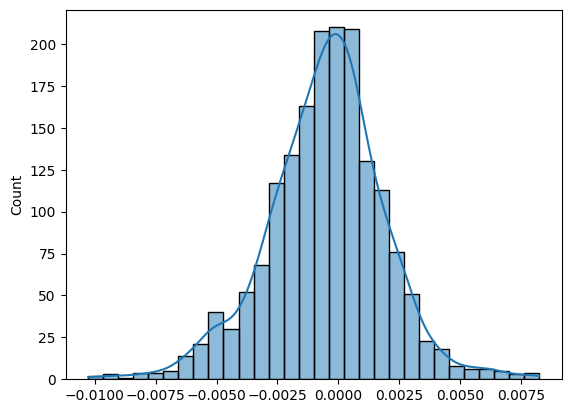

In [46]:
sns.histplot(data=grads_vgg['features.0.weight'], bins=30, kde=True)
plt.show()

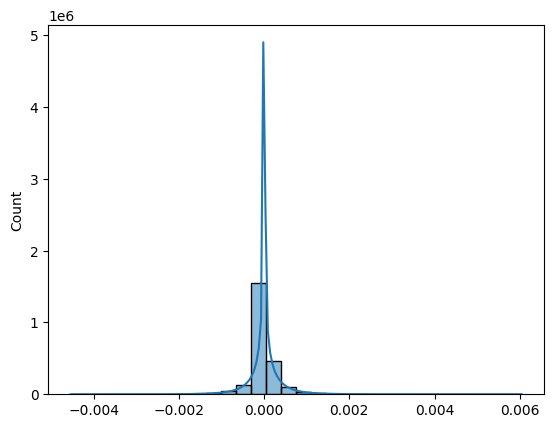

In [47]:
sns.histplot(data=grads['features.28.weight'], bins=30, kde=True)
plt.show()

In [9]:
model_fractal = FractalNet(
        data_shape=(3, 64, 64, 200),
        n_columns=4,
        init_channels=64,
        p_ldrop=0.15,
        dropout_probs=[0, 0.1, 0.2, 0.3, .4],
        gdrop_ratio=0.5,
    ).to(device)

out = model_fractal(img)

loss = criterion(out, tgt)
loss.backward()

grads_fractal = {
    name: param.grad.data.view(-1).cpu().clone().numpy()
    for name, param in model_fractal.named_parameters()
    if "weight" in name and "conv" in name and param.grad is not None
}

[block 0] Channel in = 3, Channel out = 64
[block 1] Channel in = 64, Channel out = 128
[block 2] Channel in = 128, Channel out = 256
[block 3] Channel in = 256, Channel out = 512
[block 4] Channel in = 512, Channel out = 512
Last featuremap size = 2
Total layers = 40


In [10]:
torchinfo.summary(model_fractal, (1, 3, 64, 64))

Layer (type:depth-idx)                             Output Shape              Param #
FractalNet                                         [1, 200]                  --
├─ModuleList: 1-1                                  --                        --
│    └─FractalBlock: 2-1                           [1, 64, 64, 64]           --
│    │    └─ModuleList: 3-1                        --                        414,336
│    └─MaxPool2d: 2-2                              [1, 64, 32, 32]           --
│    └─FractalBlock: 2-3                           [1, 128, 32, 32]          --
│    │    └─ModuleList: 3-2                        --                        1,920,768
│    └─MaxPool2d: 2-4                              [1, 128, 16, 16]          --
│    └─FractalBlock: 2-5                           [1, 256, 16, 16]          --
│    │    └─ModuleList: 3-3                        --                        7,675,392
│    └─MaxPool2d: 2-6                              [1, 256, 8, 8]            --
│    └─FractalBl

In [66]:
print(f'grads vgg={len(grads_vgg)}, grads fractalnet={len(grads_fractal)}')

grads vgg=16, grads fractalnet=60


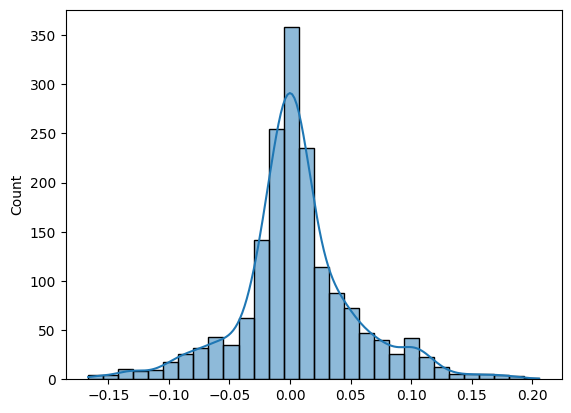

In [64]:
sns.histplot(data=grads_fractal['layers.0.columns.0.7.conv.weight'], bins=30, kde=True)
plt.show()

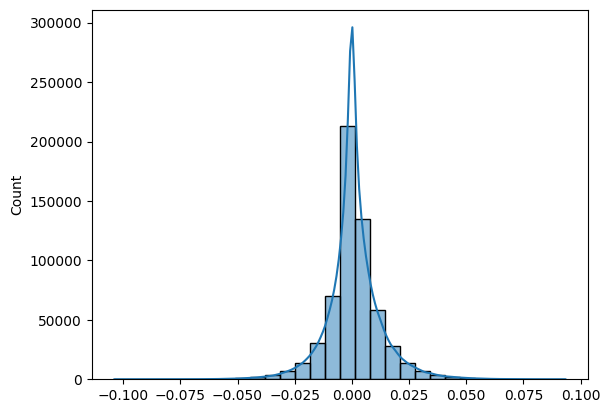

In [65]:
sns.histplot(data=grads_fractal['layers.6.columns.3.7.conv.weight'], bins=30, kde=True)
plt.show()